# Multimodal Clustering Analysis

Sep 2019  
Dongmin Kim
[underkoo@kaist.ac.kr](mailto:underkoo@kaist.ac.kr)

**Expected input data:**
Process 900 dim latent feature of multi-modal instagram posts

**What this script does:**  
Explorative data analysis on the mult-modal latent. Checks for feature correlation (features = 900 dimesnsions), applies and visualized PCA, applies t-SNE on different data (raw, PCA, etc).


In [1]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import numpy as np
import pandas as pd
import os
import seaborn as sns; sns.set()
import sklearn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from MulticoreTSNE import MulticoreTSNE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import SpectralClustering, AffinityPropagation, AgglomerativeClustering, KMeans, DBSCAN, OPTICS
import matplotlib.colors as colors
import math
import time
import config

In [2]:
# magic line to have in-notebook interactive plots
%matplotlib notebook

In [3]:
#If you want to use a korean words, unblock it!
# path_gothic = './fonts/NanumBarunGothic.ttf'
# fontprop1 = fm.FontProperties(fname=path_gothic, size=3)

In [4]:
CONFIG = config.Config

## load latent feature

In [8]:
# load raw data
target_dataset = 'instagram0830'
df_data = pd.read_csv(os.path.join(CONFIG.CSV_PATH, 'latent_' + target_dataset + '.csv'), index_col=0, header=None, encoding='utf-8-sig')
df_data.index.name = 'short_code'
#data_all = pd.read_csv('data/2019_05_01_naver_word2vec/word2vecBLOG)_1000.csv.zip', index_col=0, header=None)
print('complete csv shape: ' + str(df_data.shape))
print(df_data.iloc[:100])

complete csv shape: (97672, 900)
                  1         2         3         4         5         6    \
short_code                                                                
Bh9eo6zh3WM -0.064532 -0.065540 -0.209814 -0.021301  0.014854 -0.080327   
BoSvvEPhZMS -0.189088 -0.061798  0.148479 -0.113556  0.240953 -0.126832   
BgIh0ZjhI-d -0.113356 -0.203790 -0.030494  0.073606  0.054041  0.020635   
BhUIQpoF6gk  0.045795  0.004372 -0.166487 -0.096258 -0.052713  0.068679   
BnTl4IYg40P -0.100515 -0.241264  0.242434  0.161904 -0.174477  0.215176   
BoI9HCMhZQu -0.085147 -0.140315 -0.037167  0.080107  0.123270  0.045918   
BrKyWdQlwo8  0.008656 -0.124482 -0.047757  0.050220  0.043262 -0.016874   
BruQRNjn34Y  0.207228  0.329502  0.230217 -0.133004  0.149729 -0.068669   
Br2aY8rH2mA -0.254777 -0.200513 -0.068824  0.154603 -0.082460 -0.252173   
Bn_hS-NAq_Y  0.020322 -0.173628 -0.302585  0.020675  0.376006  0.308826   
Br69C_Qgk1T -0.307152  0.085923 -0.157152 -0.217041  0.257655 -0.03

In [ ]:
print(df_data.describe())

In [ ]:
# data seems to be well normalized to mean or median = 0 and std = 1
plt.figure()
df_data.boxplot()

## PCA as dimensionality reduction

In [ ]:
# PCA
pca = PCA(n_components=300)
df_pca_data = pd.DataFrame(pca.fit_transform(df_data))
df_pca_data.columns = ['PC' + str(i) for i in range(df_pca_data.shape[1])]
df_pca_data.index = df_data.index
print('singular_values_:\n' + str(pca.singular_values_))
print('components_:\n' + str(pca.components_))

# create PCA transformation DF
df_pca_transformation = pd.DataFrame(pca.components_).transpose()
df_pca_transformation.columns = ['PC' + str(i) for i in range(1, pca.n_components_ + 1)]
df_pca_transformation.index = df_data.columns
#print(df_pca_transformation)

In [ ]:
# PCA: plot variance explained
plt.figure()
plt.plot(pca.explained_variance_ratio_, marker='o', linestyle=':')
plt.title('PCA: explained variance')

plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle=':')
plt.title('PCA: cumulative explained variance')

In [5]:
def scatterplot_pointlabels(df_twocols, markersize=None):
    # basic scatterplot
    fig = plt.figure()
    plt.plot(df_twocols.iloc[:, 0], df_twocols.iloc[:, 1], marker='.', linestyle='None', markersize=markersize)

In [ ]:
# plot PC dimensions
for dimen1 in range(0, 5):
    for dimen2 in range(dimen1 + 1, 5):
        # subset dataframe to the PC columns we need
        df_tmp = df_pca_data.iloc[:, [dimen1, dimen2]]
        
        # plot without labels
        scatterplot_pointlabels(df_tmp)
        # plt.title(df_tmp.columns)
        plt.xlabel(df_tmp.columns[0])
        plt.ylabel(df_tmp.columns[1])
        
        # plot with labels
        #scatterplot_pointlabels(df_tmp)
        # plt.title(df_tmp.columns)
        #plt.xlabel(df_tmp.columns[0])
        #plt.ylabel(df_tmp.columns[1])

In [ ]:
#df_pca_data.to_csv(os.path.join(CONFIG.CSV_PATH, 'pca_' + target_dataset + '.csv'), encoding='utf-8-sig')
df_pca_data = pd.read_csv(os.path.join(CONFIG.CSV_PATH, 'pca_' + target_dataset + '.csv'), index_col=0, header=0, encoding='utf-8-sig')
df_pca_data.index.name = 'short_code'
print(df_pca_data.iloc[:100])

## Downsample

In [ ]:
def downsampling(df_data, num_samples=100):
    idx = int(len(df_data)/num_samples)
    idx_list = [x for x in range(0, len(df_data), idx)]
    return df_data.iloc[idx_list]

In [ ]:
ds_data = downsampling(df_data, 10000)

In [ ]:
print(ds_data)

## t-SNE

In [ ]:
def do_tsne(tsne_object, data_to_pass):
    data_tsne = pd.DataFrame(tsne_object.fit_transform(data_to_pass))
    data_tsne.index = data_to_pass.index
    data_tsne.columns = [['tsne1', 'tsne2']]
    return data_tsne

In [ ]:
# on pca
# TODO tune the learning rate and the iterations (rest should be ok i guess)
start_time = time.time()
#tsne_pca = do_tsne(TSNE(n_components=2, perplexity=50, early_exaggeration=12.0, learning_rate=100, n_iter=5000, random_state=42, verbose=1), ds_pca_data)
ds_tsne_pca = do_tsne(MulticoreTSNE(n_components=2, perplexity=250, early_exaggeration=12.0, learning_rate=10, n_iter=1000, random_state=42, n_jobs=4, verbose=1), ds_pca_data)
print("time elapsed: " + str(time.time()-start_time))

In [ ]:
# plot t-SNE with PCA
scatterplot_pointlabels(ds_tsne_pca, 1)
plt.title('t-SNE on PCA data')
plt.savefig(os.path.join(CONFIG.SVG_PATH, 'ds_tsne_pca_' + target_dataset + '.svg'))

In [ ]:
print(ds_tsne_pca.iloc[:100])
ds_tsne_pca.to_csv(os.path.join(CONFIG.CSV_PATH, 'ds_tsne_' + target_dataset + '.csv'), encoding='utf-8-sig')

In [ ]:
# on pca
# TODO tune the learning rate and the iterations (rest should be ok i guess)
start_time = time.time()
#tsne_pca = do_tsne(TSNE(n_components=2, perplexity=50, early_exaggeration=12.0, learning_rate=100, n_iter=5000, random_state=42, verbose=1), df_pca_data)
tsne_pca = do_tsne(MulticoreTSNE(n_components=2, perplexity=500, learning_rate=10, n_iter=1000, random_state=42, n_jobs=4, verbose=1), df_pca_data)
print("time elapsed: " + str(time.time()-start_time))

In [ ]:
# plot t-SNE with PCA
scatterplot_pointlabels(tsne_pca, 0.2)
plt.title('t-SNE on PCA data')
plt.savefig(os.path.join(CONFIG.SVG_PATH, 'tsne_pca_' + target_dataset + '.svg'))


In [ ]:
#tsne_pca.to_csv(os.path.join(CONFIG.CSV_PATH, 'tsne_' + target_dataset + '.csv'), encoding='utf-8-sig')
tsne_pca = pd.read_csv(os.path.join(CONFIG.CSV_PATH, 'tsne_' + target_dataset + '.csv'), index_col=0, header=0, encoding='utf-8-sig')
tsne_pca = tsne_pca.iloc[1:]
tsne_pca.index.name = 'short_code'
print(tsne_pca.iloc[:100])

In [ ]:
# on raw data
# TODO tune the learning rate and the iterations (rest should be ok i guess)
# start_time = time.time()
# tsne_raw = do_tsne(MulticoreTSNE(n_components=2, perplexity=400, early_exaggeration=12.0, learning_rate=100, n_iter=10000, random_state=42, n_jobs=4), data)
# print("time elapsed: " + str(time.time()-start_time))

In [ ]:
# plot t-SNE with raw data
# scatterplot_pointlabels(tsne_raw, plot_labels=False)
# plt.title('t-SNE on raw data')
# scatterplot_pointlabels(tsne_raw)
# plt.title('t-SNE on raw data')

## Spectral Clustering

In [ ]:
def elbow(X, max_num_clusters=10):
    sse = []
    for i in range(1, max_num_clusters):
        start_time = time.time()
        km = KMeans(n_clusters=i, init='k-means++', random_state=42)
        km.fit(X)
        print("time elapsed: " + str(time.time()-start_time))
        sse.append(km.inertia_)
    fig = plt.figure()
    plt.plot(range(1, max_num_clusters), sse, marker='o')
    plt.xlabel('num of clusters')
    plt.ylabel('SSE')
    return sse

In [ ]:
sse = elbow(tsne_pca, 50)

In [ ]:
last = len(sse) - 1
for i in range(1, last):
    distance = abs((sse[last] - sse[0]) * i - (last - 0) * sse[i] + last * sse[0] - sse[last] * 0) / math.sqrt(math.pow((sse[last] - sse[0]),2) + math.pow((last - 0),2))
    print(i, distance)

In [12]:
num_clusters = 12

In [6]:
#labeling points of tnse clusters
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']), fontsize=3, fontproperties=fontprop1)

In [ ]:
#Spectral clustering
#For using 'amg' you should install pyamg in you local computer.
# Check the component at
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html
start_time = time.time()
clustering = DBSCAN(eps=3, min_samples=5).fit(tsne_pca)
#clustering = SpectralClustering(n_clusters=num_clusters, assign_labels="discretize", affinity= 'nearest_neighbors', n_neighbors=24, random_state=42, n_jobs=4).fit(df_pca_data)
#clustering = AgglomerativeClustering(n_clusters=num_clusters).fit(data.loc[filtered_columns.index,:])# data, df_pca_data
#clustering = KMeans(n_clusters=num_clusters).fit(df_data)# data, df_pca_data
print(clustering.labels_)
print("time elapsed: " + str(time.time()-start_time))
cluster_list = np.array(clustering.labels_).tolist()
tsne_pca['cluster'] = clustering.labels_

In [14]:
clustered_df = pd.read_csv(os.path.join(CONFIG.CSV_PATH, 'clustered_optics_' + target_dataset + '.csv'), index_col=0, header=0, encoding='utf-8-sig')
clustered_df = clustered_df.iloc[1:]
clustered_df.index.name = 'short_code'
print(clustered_df.iloc[:100])

                tsne1     tsne2  cluster
short_code                              
BoSvvEPhZMS -0.434008  1.492762     1296
BgIh0ZjhI-d  1.165548 -0.027374       -1
BhUIQpoF6gk -1.001928 -1.199108     4803
BnTl4IYg40P -0.921043  0.826050       -1
BoI9HCMhZQu -0.818183  1.575726       -1
BrKyWdQlwo8 -0.198830 -1.306937     1609
BruQRNjn34Y  0.285866  1.330465     3398
Br2aY8rH2mA  0.186371  1.454137       -1
Bn_hS-NAq_Y  0.476839 -1.414515     3079
Br69C_Qgk1T -0.462695 -0.264644       -1
BsFudrehNdL -0.620251 -1.150898     2145
BlMgEb1AxuD -0.503490 -1.104008       -1
BnTf4-wgGvu -0.590947 -1.342819       -1
Bgx1HkjFoq_ -0.963021  0.412704     1267
BhUnpHaDp-c -0.123190 -0.906009       -1
BnyNSN0H5EM -1.450826 -0.215966       -1
BoG5pQpHD92  0.554920  1.241962       -1
BlK0wY_HAn8 -0.405317 -1.444098     1666
Bnn9mSzFqrv -1.095297 -0.595262     4767
BntC-EtF0mX -0.128933  0.076484      719
BjPN_94AT_v  0.946466 -1.398749       -1
BjSC2lEn7NH -0.000807  0.501431      282
BjjtqV6Aqic -0.5

In [16]:
def plot_spectral_clustering(dataframe, markersize=None):
    # plot spectrac clustering result
    # without label
    #scatterplot_pointlabels(dataframe[['x', 'y']], markersize)
    # better colors
    plt.figure(figsize=(13.2,9.6))
    #color_dict = {v: k for v, k in enumerate(sns.color_palette("Paired", num_clusters))}
    sns_plot = sns.scatterplot(x="x", y="y", hue='cluster_id', data=dataframe, marker='.', s=30)
    plt.savefig(os.path.join(CONFIG.SVG_PATH, 'spectralclustering_' + target_dataset + '.svg'))

x             float64
y             float64
word           object
cluster_id      int64
dtype: object


<IPython.core.display.Javascript object>


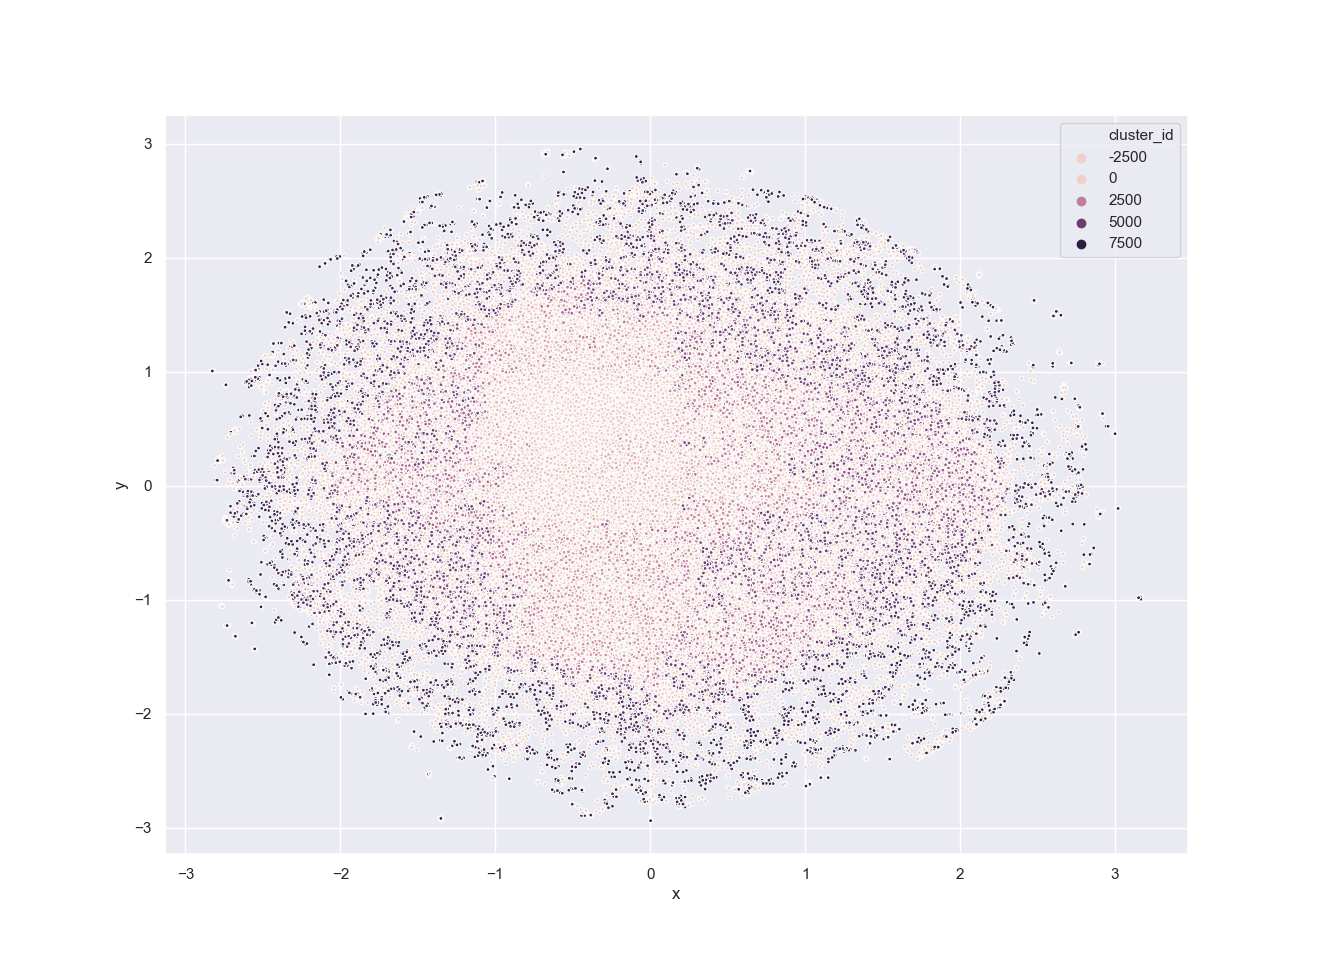

In [17]:
# put clustering info into df
df_clustered_spectral = pd.DataFrame({'x': clustered_df.tsne1.squeeze(), 
                                      'y': clustered_df.tsne2.squeeze(), 
                                      'word': clustered_df.index.tolist(), 
                                      'cluster_id': clustered_df.cluster})
# debug prints
# print(df_clustered_spectral.shape)
print(df_clustered_spectral.dtypes)
plot_spectral_clustering(df_clustered_spectral, 0.2)       
#ds_clustered_spectral = downsampling(df_clustered_spectral, 5000)
#plot_spectral_clustering(ds_clustered_spectral, 0.2)       
# print(df_clustered_spectral.iloc[:10, :])
# df_clustered_spectral['cluster_id'].describe() # 30 integer clusters